# IMDB Project

---

[![badge](https://img.shields.io/static/v1?label=OPER+3384++%E2%80%A2++Predictive+Analytics&message=Project%20Team%2010&style=plastic&logo=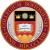&color=red)](https://mybinder.org/v2/gh/tavlarios/OPER3384/HEAD?filepath=IMDB%20Project.ipynb)

# Research

In [190]:
import pandas as pd
import numpy as np
import collections
import itertools
import operator
import re
import os
import tqdm
import random


#################################
####==Statistics Libraries==####
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction import DictVectorizer

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import scipy

import patsy
#################################

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio    #==> pio.renderers


import qgrid
from pandas_profiling import ProfileReport
from pandas_summary import DataFrameSummary


pd.options.display.max_rows     = None
pd.options.display.max_columns  = None

## Data Module

In [210]:
class DataModule:
    
    def __init__(self):
        self.dforig = self._import_data()
        self.dfconfig = self._config_original_df(dataframe=self.dforig)
        self.DF = self.dfconfig
        
        # self.df_actors = self._get_df_category(dataframe=self.dforig, target_column='Actors')
        self.df_genres = self._get_df_category(dataframe=self.dfconfig, target_column='Genre')
        # self.df_nGenres = self.df_genres.apply(lambda row: sum(row[:]), axis=1).to_frame().rename(columns={0:'n_Genre'})
        # self.mlr_genre2rev = self.get_MLR(self.df_genres, self.dforig[['Revenue_Millions']])
        
        self.LabelEncoderMap = {}
        
    def _import_data(self):
        df_raw = pd.DataFrame()
        try:
            if os.path.exists('IMDB-Movie-Data.csv'):
                df_raw = pd.read_csv("IMDB-Movie-Data.csv")
            else:
                df_raw = pd.read_csv("https://raw.githubusercontent.com/tavlarios/OPER3384/main/IMDB-Movie-Data.csv")
        except:
            raise Exception('Could not locate CSV of IMDB Movie Data.')
            
        if (('Runtime' in df_raw.columns) and ('Revenue' in df_raw.columns)):
            pass
        else:
            df_raw = df_raw.rename(columns={
                'Runtime (Minutes)':'Runtime',    # minutes
                'Revenue (Millions)':'Revenue',  # millions of dollars
            })
        
        df_raw['hash'] = df_raw.apply(lambda x: hash(tuple(x)), axis=1)
        df_raw = df_raw.set_index('hash')
        return df_raw
    
    def _config_original_df(self, dataframe):
        df = dataframe
        # df['Genre_unsorted']   = df['Genre'].apply(lambda x: tuple() if (isinstance(x,str)==False) else tuple(list(i.strip().upper() for i in str(x).split(','))))
        
        df['Genre']   = df['Genre'].apply(lambda x: [] if (isinstance(x,str)==False) else sorted(list(i.strip().upper() for i in str(x).split(','))))
        df['Genre']   = df['Genre'].apply(lambda x: tuple(x))  # <!==TEST==!-- see if this is compatible
        df['Actors']  = df['Actors'].apply(lambda x: [] if (isinstance(x,str)==False) else sorted(list(i.strip().upper() for i in str(x).split(','))))
        
        return df
        
    def _get_df_category(self, dataframe, target_column:str):
        df, target_column = dataframe, target_column
        
        hash2cats  = dict((k, [i.strip().upper() for i in v]) for k,v in df[target_column].to_dict().items())
        all_cats   = [s.strip().upper() for s in list(set(itertools.chain.from_iterable(list(hash2cats.values()))))]
        
        hash2allCats = {}
        for h,cats in hash2cats.items():
            hash2allCats[h] = {}
            for c in all_cats:
                if c in cats:
                    hash2allCats[h][c] = 1
                else:
                    hash2allCats[h][c] = 0
               
        df_cats = pd.DataFrame.from_dict(hash2allCats).T
        df_cats.index.name = 'hash'
        return df_cats
    
    def getNormalized(self, dataframe, target_columns=None, set_min_val=None, set_max_val=None):
        '''Normalizes values by column.
            
            Parameters
            ----------
                target_columns : list, `all`
                    - If a list is provided, it will normalize
                        each column in the list.
                    - If `all` is selected, all columns will
                        be normalized.
            Returns
            -------
                pd.DataFrame        
        '''
        if isinstance(dataframe, pd.DataFrame):
            if target_columns==None:
                return dataframe
            else:
                df = dataframe
                tcols = list(df.columns) if (target_columns==all) else target_columns

                for c in tcols:
                    if c in df.columns:
                        min_val = min(df[c]) if (set_min_val==None) else set_min_val
                        max_val = max(df[c]) if (set_max_val==None) else set_max_val
                        df[c] = (df[c] - min_val) / (max_val - min_val)
                return df
        elif isinstance(dataframe, pd.Series):
            ser = dataframe
            min_val = min(ser) if (set_min_val==None) else set_min_val
            max_val = max(ser) if (set_max_val==None) else set_max_val
            normSer = (ser - min_val) / (max_val - min_val)
            return ser
    
    def get_MLR(self, X_df, y_df):
        dfx, dfy = X_df[sorted(X_df.columns)], y_df
        df = dfx.merge(dfy[dfy.columns], how='outer', left_index=True, right_index=True).dropna(how='any', axis=0)
        
        #====statsmodels Method====#
        y = df[dfy.columns]
        X = df[dfx.columns]
        X = sm.add_constant(X)
        
        ols_model = statsmodels.regression.linear_model.OLS(y, X, missing='drop')
        ols_results = ols_model.fit()
        
        df_ols = pd.DataFrame((ols_results.summary().tables)[1]).set_index(0)
        df_ols.columns = df_ols.iloc[0]
        df_ols = df_ols.iloc[1:,:]
        df_ols.index.name = 'Genre'
        
        sorted_params = {k: v for k, v in sorted(dict(ols_results.params).items(), key=operator.itemgetter(1), reverse=True)}
        
        return (ols_results, df_ols, sorted_params)

    
    def get_dfDiscrete(self, dataframe:pd.DataFrame,
                       equal_quantiles=False,
                       include_Revenue=False,
                      ):
        df = dataframe.copy()
        bin_map = {    # <==DEFAULT PARAMS
            'Runtime' : {
                'q'      : 3,
                'labels' : ['Short','Medium','Long'],
            },
            'Rating' : {
                'q'      : 10,
                'labels' : False,
            },
            'Votes' : {
                'q'      : 10,
                'labels' : False,
            },
            'Metascore' : {
                'q'      : 10,
                'labels' : False,
            },
        }
        
        if equal_quantiles!=False:
            fields = ['Runtime','Rating','Votes','Metascore']                
            if equal_quantiles==True:
                bin_map = dict((f,{'q':10,'labels':False}) for f in fields)
            elif isinstance(equal_quantiles, int):
                bin_map = dict((f,{'q':equal_quantiles,'labels':False}) for f in fields)
                
        if include_Revenue!=False:
            revenue_q = 10
            if isinstance(include_Revenue, int):
                revenue_q = include_Revenue
            elif ((include_Revenue==True) and (isinstance(equal_quantiles, int))):
                revenue_q = equal_quantiles
            bin_map = {**bin_map, **{'Revenue':{'q':revenue_q, 'labels':False}}}
            
        
        for col,params in bin_map.items():
            df[col] = pd.qcut(df[col], q=params['q'], labels=params['labels'])
        
        LE_Genre = LabelEncoder()
        df['LE_Genre'] = LE_Genre.fit_transform(df['Genre'])
        leCode2GenreSet = dict(zip(list(set(df['LE_Genre'].values)), LE_Genre.classes_))
        self.LabelEncoderMap = {**self.LabelEncoderMap, **{'LE_Genre':leCode2GenreSet}}
        
        ##==Rough way of getting back to tuples
        ##  dfdis['LE_2_Genre'] = dfdis['LE_Genre'].map(dfdis.drop_duplicates(subset=['LE_Genre']).set_index('LE_Genre')['Genre'])
        ##==##
        
        return df
        
    def readPatsy(self, coef):
        coef = str(coef)
        interactions = coef.split(':')
        coef_parts = []
        for i in interactions:
            if ('[T.' in i): # <-- reminds you that these columns are treatment coded
                i_type   = 'categorical'
                i_factor, i_labelEncode = '', ''
                if (i[:2]=='C('):  # <-- formula-explicit categorical
                    i_regex  = re.findall(r'C\(([^)]+)\)\[T\.(.*?)\]', i)[0]
                    i_factor = i_regex[0]
                    _i_labelEncode = i_regex[1]
                    if _i_labelEncode.isdigit():
                        i_labelEncode = int(_i_labelEncode)
                else:
                    i_regex  = re.findall(r'(\w+)\[T\.(.*?)\]', i)[0]
                    i_factor = i_regex[0]
                    _i_labelEncode = i_regex[1]
                    if _i_labelEncode.isdigit():
                        i_labelEncode = int(_i_labelEncode)

                i_dict = {
                    'type'               : i_type,
                    'factor'             : i_factor,
                    'LabelEncoderMap_key'  : i_labelEncode,
                    'full_text'          : i,
                }
                coef_parts.append(i_dict)

            else:
                i_type = 'numerical'
                i_factor = i

                i_dict = {
                    'type'               : i_type,
                    'factor'             : i_factor,
                    'LabelEncoderMap_key'  : np.nan,
                    'full_text'          : i,
                }
                coef_parts.append(i_dict)
                
        if len(self.LabelEncoderMap)==0:
            _ = self.get_dfDiscrete(self.DF)
        dfp = pd.DataFrame(coef_parts)
        dfp['factor_values'] = dfp.apply(lambda row: np.nan if (np.isnan(row['LabelEncoderMap_key'])) else self.LabelEncoderMap.get(row['factor']).get(int(round(row['LabelEncoderMap_key']))), axis=1)
        
        return dfp
    def getLabelDecodedValue(self, coef_string:str):
        coef = coef_string
        dfc = self.readPatsy(coef_string)
        ser_factorValues = dfc.set_index('factor')['factor_values'].to_dict()
        return ser_factorValues
        
    

In [211]:
data = DataModule()

### Viewing Dataset

In [ ]:
qgrid.show_grid(data.DF, show_toolbar=True, grid_options={'forceFitColumns':False})

In [ ]:
dfdis = data.get_dfDiscrete(data.DF, equal_quantiles=True)
dfdis

### Quick Comparison – *Revenue*

**Questions**
- What is correlated to revenue?
    - Rating
    - Metascore (comes from Metacritic.com)
- Should rating be weighted for the # of votes
    - Is there a relationship between # of votes and rating? ... Since popular movies more likely to receive more votes.
        - If so, then there should probably be a sub-model accounting for this.
    - There is probably a relationship b/w Votes and Revenue, since people who vote are more likely (than not) to have purchased access to see the movie at some point.
    
---

**Process**
1. Find out which factors {F1} have the greatest impact on Revenue
2. Determine which factors {F2} have the greatest predictive power on {F1}
3. Use {F2} to predict {F1}
    1. Use {F1} to predict Y
    
More general step: figure out which predictive-level to place each factor.

In [ ]:
# data.DF.corr()

#### Plots

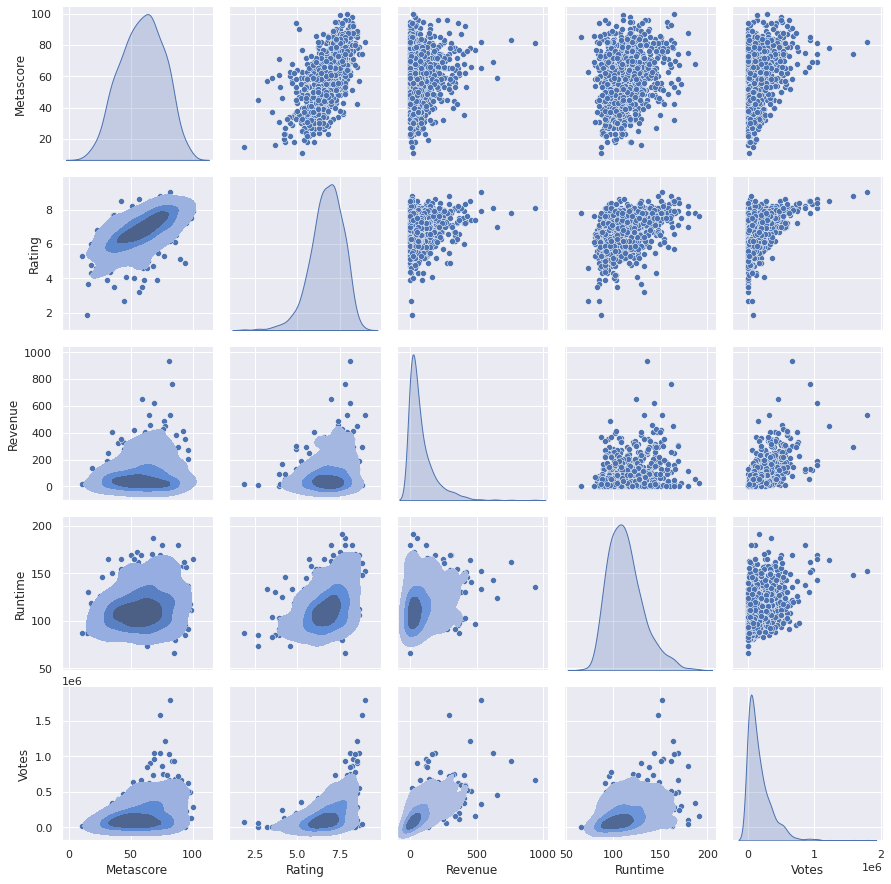

In [191]:
ax_pp = sns.pairplot(data=data.DF[data.DF.columns.difference(['Year','Rank'])], diag_kind="kde")
ax_pp.map_upper(sns.regplot, fit_reg=True, truncate=True)
ax_pp.map_lower(sns.kdeplot, shade=True, thresh=0.05, levels=4)
plt.show()

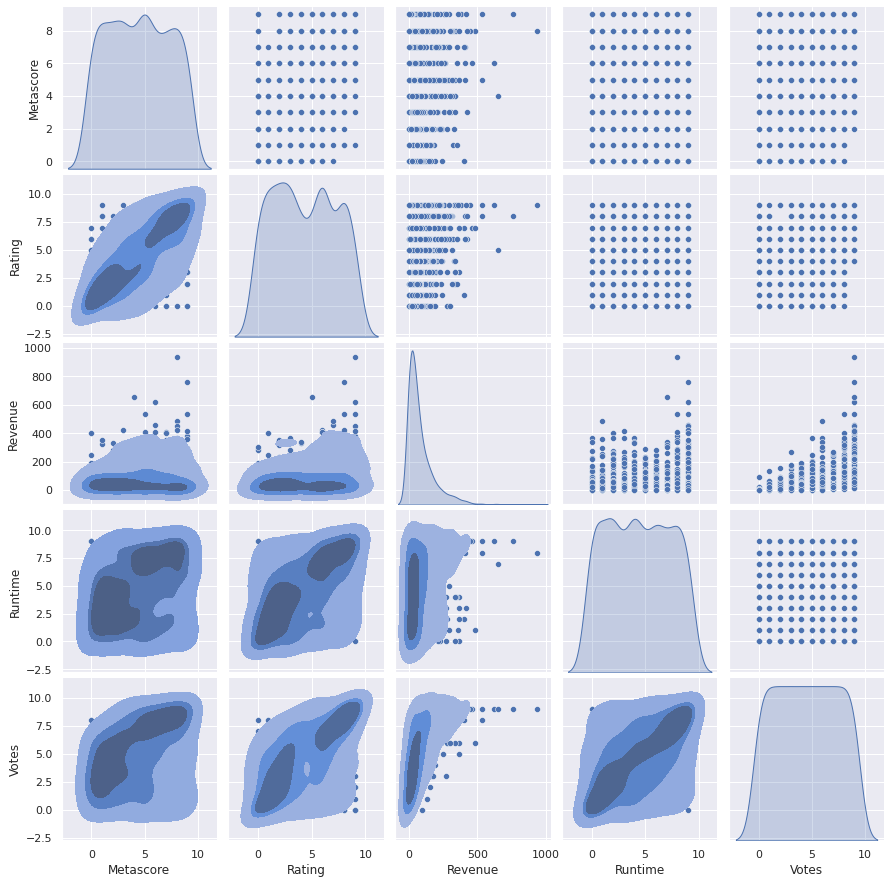

In [194]:
ax_pp = sns.pairplot(data=data.get_dfDiscrete(DataModule().DF, True)[['Metascore','Rating','Revenue','Runtime','Votes']], diag_kind="kde")
ax_pp.map_upper(sns.regplot, fit_reg=True, truncate=True)
ax_pp.map_lower(sns.kdeplot, shade=True, thresh=0.05, levels=4)
plt.show()

#### MLR Models

##### Original Data

In [195]:
mod1 = smf.ols(formula='Revenue ~ Metascore + Rating + Votes', data=data.DF).fit()
(mod1.summary2())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.421    
Dependent Variable: Revenue          AIC:                9716.7946
Date:               2020-11-07 17:14 BIC:                9735.7187
No. Observations:   838              Log-Likelihood:     -4854.4  
Df Model:           3                F-statistic:        203.7    
Df Residuals:       834              Prob (F-statistic): 4.10e-99 
R-squared:          0.423            Scale:              6327.0   
-------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept   136.7345   24.5042   5.5801  0.0000   88.6375  184.8316
Metascore     0.0834    0.2193   0.3802  0.7039   -0.3470    0.5137
Rating      -19.3831    4.6669  -4.1533  0.0000  -28.5434  -10.2228
Votes         0.0004    0.0000  23.3034  0.0000    0.0004    0.0004
------------------------------------------------------------------
Omnibus:              446.177      Durbin-Watson:         1.892   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      5593.745
Skew:                 2.125        Prob(JB):              0.000   
Kurtosis:             14.922       Condition No.:         2472111 
==================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [196]:
mod2 = smf.ols(formula='Revenue ~ Metascore * Rating * Votes', data=data.DF).fit()
(mod2.summary2())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.471    
Dependent Variable:     Revenue            AIC:                  9644.5959
Date:                   2020-11-07 17:14   BIC:                  9682.4440
No. Observations:       838                Log-Likelihood:       -4814.3  
Df Model:               7                  F-statistic:          107.5    
Df Residuals:           830                Prob (F-statistic):   7.75e-112
R-squared:              0.476              Scale:                5777.3   
--------------------------------------------------------------------------
                         Coef.   Std.Err.    t    P>|t|    [0.025   0.975]
--------------------------------------------------------------------------
Intercept              -127.9933  87.5289 -1.4623 0.1440 -299.7973 43.8106
Metascore                 2.7516   1.4930  1.8430 0.0657   -0.1789  5.6822
Rating                   19.5748  13.6905  1.4298 0.1531   -7.2972 46.4469
Metascore:Rating         -0.4254   0.2207 -1.9277 0.0542   -0.8586  0.0078
Votes                     0.0017   0.0006  2.7953 0.0053    0.0005  0.0029
Metascore:Votes          -0.0000   0.0000 -0.1114 0.9113   -0.0000  0.0000
Rating:Votes             -0.0002   0.0001 -2.2812 0.0228   -0.0004 -0.0000
Metascore:Rating:Votes    0.0000   0.0000  0.3827 0.7020   -0.0000  0.0000
--------------------------------------------------------------------------
Omnibus:                503.030        Durbin-Watson:           1.855     
Prob(Omnibus):          0.000          Jarque-Bera (JB):        7538.061  
Skew:                   2.434          Prob(JB):                0.000     
Kurtosis:               16.864         Condition No.:           5239918714
==========================================================================
* The condition number is large (5e+09). This might indicate
strong multicollinearity or other numerical problems.
"""

##### Quantile Regression

> ***NOTE***: Much higher $R^{2}$ when excluding intercept (0.54 --> 0.87+)

In [199]:
nQuantiles_for_regression = 20

In [204]:
mod1q = smf.ols(formula='Revenue ~ Metascore + Rating + Votes + Runtime -1', data=data.get_dfDiscrete(DataModule().DF, nQuantiles_for_regression, True)).fit()
mod1q.summary2()

In [206]:
mod2q = smf.ols(formula='Revenue ~ Metascore * Rating * Votes * Runtime -1', data=data.get_dfDiscrete(DataModule().DF, nQuantiles_for_regression, True)).fit()
mod2q.summary2()

In [ ]:
# sm.stats.anova_lm(mod1q, typ=1)

## Directors

**Questions**
- Do movies that do not contain the Director's primary genre perform better or worse than those that do contain the Director's primary genre?


In [4]:
class Director:
    
    def __init__(self):
        
        self.DF = data.DF.copy()
        
    def _get_dfDirector(self):
        
        ##==Basic Aggregation==## 
        dfd = data.DF.groupby(by=['Director','Year']).agg({
            'Title'      : list,
            'Genre'      : list,
            'Runtime'    : 'mean',
            'Rating'     : 'mean',
            'Votes'      : 'sum',
            'Revenue'    : 'sum',
            'Metascore'  : 'mean',    
        }).sort_values(by=['Revenue'], ascending=False)
        
        
        pass
    
    
    def _get_weight4variable(self, dataframe=None, groupby_variables='Director', weight_columns=all):
        '''
            Uses base DataFrame (``self.DF``)
        '''
        DF = dataframe if isinstance(dataframe, pd.DataFrame) else self.DF.copy()
        groupby_list = [groupby_variables] if isinstance(groupby_variables,str) else (groupby_variables if isinstance(groupby_variables,list) else ['Director'])
        grouped = DF.groupby(by=groupby_list)
        
        weight_cols = list(k for k,v in DF.dtypes.to_dict().items() if (np.issubdtype(v, np.number)))  if (weight_columns==all)   else ([weight_columns] if isinstance(weight_columns,str) else weight_columns)
        newDF = DF
        for wc in weight_cols:
            weightCol_name = str('WEIGHT_' + wc)
            newDF[weightCol_name] = grouped[wc].transform(lambda x: (x / x.sum()))
            
        return newDF
    
    def getWeightedAverage(self,
                           ##--> Weight variables based on Revenue
                           # average_cols:list=['Rating','Metascore'],
                           # weight_basis='Revenue',
                           
                           ##--> Weight variables based on votes
                           average_cols=['Metascore','Rating'],
                           weight_basis='Votes',
                          ):
        '''Gets weighted averages for each Director.
        
            Returns
            -------
                pd.DataFrame
        '''
        
        df = self.DF.copy().reset_index().astype({'hash':object})
        dfw = self._get_weight4variable(dataframe=df, groupby_variables='Director', weight_columns=[weight_basis])
        WEIGHT_cols = [col for col in dfw.columns if (col[:7]=='WEIGHT_')]
        
        for ac in average_cols:
            for wc in WEIGHT_cols:
                ac_name = str(wc.lstrip('WEIGHT_') + '_WAVG_' + ac)
                dfw[ac_name] = dfw[ac] * dfw[wc]
        
        # dfw_dtypes_num = list(dfw.select_dtypes(include=np.number).columns)
        dfw_list_cols = list(dfw.select_dtypes(include=object).columns)
        dfw_sum_cols = [col for col in dfw.columns if (('WEIGHT_' in col) or ('_WAVG_' in col) or (col=='Revenue'))]
        
        aggDict = dict((col, 'sum') if (col in dfw_sum_cols) else ((col,list) if col in dfw_list_cols else (col,'mean')) for col in dfw.columns)
        
        # aggDict = dict((col, 'sum') if ((col in dfw_dtypes_num) )#and (col not in ['Year','Runtime','Rank','Metascore','Rating']))
        #                else (col,list) for col in dfw.columns)
        dfd = dfw.groupby(by=['Director']).agg(aggDict)
        
        for ocol in list(dfw.select_dtypes(include=object).columns):
            dfd[ocol] = dfd.apply(lambda row: dict(zip(row['hash'],row[ocol])), axis=1)
        
        dfd = dfd.sort_values(ascending=False,
                              # by=average_cols,
                              by=['Revenue'],
                             )
        dfd = dfd[dfd.columns.difference(['Director','hash'])]
        
        return dfd
        
        
    def getDirector2Genre(self):
        DFG = data.df_genres.copy()
        DFG['Director'] = DFG.index.map(data.DF['Director'])
        DFG = DFG.groupby(by='Director', axis=0).sum()
        DFG['total_movies'] = DFG.sum(axis=1)
        DFG = DFG.sort_values(by='total_movies',ascending=False).drop(columns=['total_movies'])
        return DFG
    
    def __getter__df_DirectorGenreMix(self):
        DFG = data.df_genres.copy()
        DFG['Director'] = DFG.index.map(data.DF['Director'])
        DFG = DFG.groupby(by='Director', axis=0).sum()
        DFG['total_movies'] = DFG.sum(axis=1)
        DFG = DFG.sort_values(by='total_movies',ascending=False).drop(columns=['total_movies'])
        self._df_DirectorGenreMix = DFG
        return self._df_DirectorGenreMix
    def __setter__df_DirectorGenreMix(self, dataframe):
        return self._df_DirectorGenreMix
    df_DirectorGenreMix = property(__getter__df_DirectorGenreMix, __setter__df_DirectorGenreMix)
        
    def __getter__Director2PrimaryGenre(self):
        dfg = DIR.df_DirectorGenreMix.copy()
        dfg['Genre'] = dfg.apply(lambda row: row.idxmax(), axis=1)
        ser_primaryGenre = dfg['Genre']
        # genre_2_nPrimary = ser_primaryGenre.groupby(ser_primaryGenre).count()  #<-- {key[Genre] : value[# of Directors with <Genre> as their primary]}
        del dfg
        self._Director2PrimaryGenre = ser_primaryGenre
        return self._Director2PrimaryGenre
    def __setter__Director2PrimaryGenre(self, obj):
        return self._Director2PrimaryGenre
    Director2PrimaryGenre = property(__getter__Director2PrimaryGenre, __setter__Director2PrimaryGenre)
    
    
    def getDF_withPrimaryGenre(self):
        dff = data.get_dfDiscrete().sort_values(by=['Revenue'])
        dff['Director_primaryGenre'] = dff['Director'].map(self.Director2PrimaryGenre)
        dff['Director_inGenreScope'] = dff.apply(lambda row: True if (row['Director_primaryGenre'] in row['Genre']) else False, axis=1)
        genreOutScope = dff[dff['Director_inGenreScope']==False]
        genreOutScope.sort_values(by='Revenue', ascending=False)
        return genreOutScope
    
    

In [5]:
DIR = Director()

In [ ]:
dfw = DIR.getWeightedAverage()

In [ ]:
dfw.head()

## Genres

In [6]:
class Genre:
    
    def __init__(self):
        self.DF = data.DF.copy()
        self.df_genres = data.df_genres.copy()
        self.all_genres = list(set(itertools.chain.from_iterable(list(data.DF['Genre'].values))))
    
    #################################
    ####====Genre vs. Revenue====####
    def _get_hash2genreRev(self):
        '''Returns Genre-contribution of Revenue.
        '''
        dfg = self.df_genres
        # dfg = dfg.rename_axis('Genre',ais='columns')
        revPerGenre = dfg.index.map(self.DF['Revenue']) / dfg.sum(axis=1)
        dfgen = dfg.multiply(revPerGenre, axis=0)
        dfgen = dfgen.rename_axis('Genre', axis=1)
        self._hash2genreRev = dfgen
        return self._hash2genreRev
    
    def __setter__hash2genreRev(self, obj):
        return self._hash2genreRev
    hash2genreRev = property(_get_hash2genreRev, __setter__hash2genreRev)
    
    def __getter__HashGenreRev(self):
        '''
            GEN.hash2genreRev.stack().reset_index().rename(columns={0:'Revenue'}).replace(0,np.nan).dropna(axis=0,how='any')
        '''
        df = self._get_hash2genreRev()
        df = df.stack().reset_index().rename(columns={0:'Revenue'})
        # df = df.loc[:, ()]
        pass
    
    def __getter__genre2revenue_allTime(self):
        hash2genRev = self._get_hash2genreRev()
        gen2rev_allTime = hash2genRev.sum().sort_values(ascending=False)
        self._gen2rev_allTime = gen2rev_allTime
        return self._gen2rev_allTime
    def __setter__genre2revenue_allTime(self, obj):
        return self._gen2rev_allTime
    genre2revenue_allTime = property(__getter__genre2revenue_allTime, __setter__genre2revenue_allTime)
    
    def __getter__genre2revenue_byYear(self):
        df = self._get_hash2genreRev()
        df['Year'] = df.index.map(self.DF['Year'])
        dfgy = df.groupby('Year').sum()
        self._gen2rev_byYear = dfgy
        return self._gen2rev_byYear
    def __setter__genre2revenue_byYear(self, obj):
        return self._gen2rev_byYear
    genre2revenue_byYear = property(__getter__genre2revenue_byYear, __setter__genre2revenue_byYear)
    #################################
    
    #################################
    ####====Genre vs. Runtime====####
    def _get_hash2genreRuntime(self):
        dft = self.df_genres
        rtPerGenre = dft.index.map(self.DF['Runtime']) / dft.sum(axis=1)
        dfrt = dft.multiply(rtPerGenre, axis=0)
        dfrt = dfrt.rename_axis('Genre', axis=1)
        self._hash2genreRuntime = dfrt
        return self._hash2genreRuntime
    
    def __setter__hash2genreRuntime(self, obj):
        return self._hash2genreRuntime
    hash2genreRuntime = property(_get_hash2genreRuntime, __setter__hash2genreRuntime)
    
    def __getter__genre2totalRuntime(self):
        df = self._get_hash2genreRuntime()
        df['Year'] = df.index.map(self.DF['Year'])
        dfgy = df.groupby('Year').sum()
        self._genre2totalRuntime = dfgy
        return self._genre2totalRuntime
    def __setter__genre2totalRuntime(self, obj):
        return self._genre2totalRuntime
    genre2totalRuntime = property(__getter__genre2totalRuntime, __setter__genre2totalRuntime)
    
    
    #################################
    
    def _get_allGenreCombos(self):
        
        combos_tuples = sorted(set(tuple(sorted(tuple(set(l)))) for l in itertools.combinations_with_replacement(list(data.df_genres.columns), 3)))
        combos_lists = [list(i) for i in sorted(set(tuple(sorted(tuple(set(l)))) for l in itertools.combinations_with_replacement(list(data.df_genres.columns), 3)))]
        
        combo2hash = dict((hash('&'.join(combo)), combo) for combo in combos_lists)
        return combo2hash
        
    

In [7]:
GEN = Genre()

### Genre Plots

#### Genre vs. Revenue

In [ ]:
fig = px.area(
    data_frame=GEN.genre2revenue_byYear.rename_axis('Genre', axis=1),
    title='Revenue by Genre – Animation, Action, & Adventure',# (log scale)',
    labels={'value':'Revenue (Millions, $)'},
    # log_y=True,
)
fig.show()

In [ ]:
fig = px.area(
    data_frame=GEN.genre2revenue_byYear.rename_axis('Genre', axis=1),
    title='Revenue Contribution by Genre',
    labels={'value':'Contribution of Total Revenue (%)'},
    line_shape='spline',
    groupnorm='percent',
)
fig.show()

In [ ]:
fig = px.violin(
    data_frame=GEN.hash2genreRev[list(GEN.genre2revenue_allTime.index.values)].stack().reset_index().rename(columns={0:'Revenue'}).replace(0,np.nan).dropna(axis=0,how='any'),
    y="Revenue", x="Genre",
    color="Genre",
    box=True, #points='all',
    title='Revenue Distribution for All Movies by Genre',
    labels={'Revenue':'Revenue (Millions, $)'},
)
fig.show()

In [ ]:
fig = px.violin(
    data_frame=GEN.hash2genreRev[['ADVENTURE','ACTION','ANIMATION']].stack().reset_index().rename(columns={0:'Revenue'}).replace(0,np.nan).dropna(axis=0,how='any'),
    y="Revenue", x="Genre",
    color="Genre",
    box=True, points='all',
    title='Revenue Distribution for All Movies – Adventure, Action, & Animation',
    labels={'Revenue':'Revenue (Millions, $)'},
)
fig.show()

#### Genre vs. Runtime

In [ ]:
dfruntimeProp   = GEN.hash2genreRuntime[list(GEN.genre2revenue_allTime.index.values)].stack().reset_index().rename(columns={0:'Runtime'}).replace(0,np.nan).dropna(axis=0,how='any')
dfruntimeProp['Year']   = dfruntimeProp['hash'].map(data.DF['Year'])
dfruntimeUnAdj  = GEN.df_genres.multiply(GEN.DF['Runtime'], axis=0).rename_axis('Genre',axis=1).stack().reset_index().rename(columns={0:'Runtime'}).replace(0,np.nan).dropna(axis=0,how='any')
dfruntimeUnAdj['Year']   = dfruntimeUnAdj['hash'].map(data.DF['Year'])

dfruntimeProp_C, dfruntimeUnAdj_C  = dfruntimeProp, dfruntimeUnAdj
dfruntimeProp_C['Calculation_Type'], dfruntimeUnAdj_C['Calculation_Type'] = 'Proportional', 'Unadjusted'
dfruntimeComp = pd.concat([dfruntimeProp_C, dfruntimeUnAdj_C], ignore_index=True, sort=False)
dfruntimeComp.sample(10)

In [ ]:
fig = px.violin(
    data_frame=dfruntimeProp,
    y="Runtime", x="Genre",
    color="Genre",
    box=True, #points='all',
    title='Runtime Distribution for All Movies – All Genres',
    labels={'Revenue':'Runtime (Minutes)'},
)
fig.show()

In [ ]:
fig = px.violin(
    data_frame=dfruntimeUnAdj,
    y="Runtime", x="Genre",
    color="Genre",
    box=True, #points='all',
    title='Unadjusted-Runtime Distribution for All Movies – All Genres',
    labels={'Revenue':'Runtime (Minutes)'},
)
fig.show()

In [ ]:
fig = px.area(
    data_frame=dfruntimeProp.groupby(['Year','Genre'])['Runtime'].sum().reset_index().rename(columns={0:'Runtime'}),
    y='Runtime', x='Year', color='Genre',
    groupnorm='percent',
    title='Contribution of Total Runtime for All Movies – All Genres',
    labels={'Runtime':'Contribution of Total Runtime (%)'},
)
fig.show()

##### Runtime Calculation Comparison

Proportional vs. Unadjusted

In [ ]:
dfcomptgt = dfruntimeComp[dfruntimeComp['Genre'].isin(['ADVENTURE','ACTION','ANIMATION'])]
dfcomptgt.columns

In [ ]:
fig = px.violin(
    data_frame=dfcomptgt,
    y="Runtime", x="Genre", color='Calculation_Type',
    # color="Genre",
    box=True, points='all',
    title='',
    # labels={'Revenue':'Runtime (Minutes)'},
)
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(x=dfcomptgt['Genre'][ dfcomptgt['Calculation_Type']=='Proportional' ],
                        y=dfcomptgt['Runtime'][ dfcomptgt['Calculation_Type'] == 'Proportional' ],
                        legendgroup='Proportional', scalegroup='Proportional', name='Proportional',
                        side='negative',
                        yaxis="y",
                        line_color='blue',
                       )
             )
fig.add_trace(go.Violin(x=dfcomptgt['Genre'][ dfcomptgt['Calculation_Type']=='Unadjusted' ],
                        y=dfcomptgt['Runtime'][ dfcomptgt['Calculation_Type'] == 'Unadjusted' ],
                        legendgroup='Unadjusted', scalegroup='Proportional', name='Unadjusted',
                        side='positive',
                        yaxis="y2",
                        line_color='red',
                        # alignmentgroup=
                       )
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

## Actors

In [122]:
class Actors:
    
    def __init__(self):
        self.DF = data.DF.copy()
        
        self.all_actors = list(set(itertools.chain.from_iterable(list(data.DF['Actors'].values))))
        
    def _get_hash2actor(self):
        df = data._get_df_category(dataframe=data.DF, target_column='Actors')
        df = df.rename_axis('Actor',axis=1)
        self._hash2actor = df
        return self._hash2actor
    def __setter__hash2actor(self, obj):
        return self._hash2actor
    hash2actor = property(_get_hash2actor, __setter__hash2actor)
    
    def _add_sumToDescribe(self, df):
        dfd = df.T
        dfd['sum'] = dfd['count'] * dfd['mean']
        return dfd.T
    def describeByGenre(self, df_actor, describe_include=[np.number]):
        dfa = df_actor
        ##--Original sum method--##
        # dict_describe_ = dict(
        #     (genre,
        #      dfa[dfa['Genre'].apply(lambda x: genre in x)].describe(include=describe_include)#.unstack()
        #     ) for genre in GEN.all_genres)
        # dict_describe = dict((k, (self._add_sumToDescribe(v)).unstack()) for k,v in dict_describe_.items())
        
        ##--New sum method (doing it in getActorStats--##
        dict_describe_ = dict(
            (genre,
             dfa[dfa['Genre'].apply(lambda x: genre in x)].describe(include=describe_include).unstack()
            ) for genre in GEN.all_genres)
        dict_describe = dict_describe_
        
        ser_describe = pd.concat(dict_describe)
        return ser_describe
    
    def getActorStats(self, limit=10, sample=False, min_appearances=2):
        '''Returns descriptive statistics for each Actor.
        
            Parameters
            ----------
                limit : {None, int}
                    This will limit the operation to the
                    top n actors (by # of appearances).
        
            Statistics
            ----------
                - Average Rating
                    - Overall
                    - by Genre
                - # of Appearances
                - Runtime
                - Total Votes
                
            dfAS.loc(axis=0)[:,'Rating',['mean']].T.idxmax(axis='index')
        '''
        df = self.DF
        all_actors, actors_list = self.all_actors, []
        if limit==None:
            actors_list = all_actors
        else:
            if sample==False:
                actors_list = [i[0] for i in collections.Counter(data.DF.agg('sum')['Actors']).most_common()[:(min(limit, len(self.all_actors)))] if (i[1]>=min_appearances)]
            else:
                sample_k = int(sample*len(all_actors)) if (isinstance(sample, float) and (sample<1.0)) else limit
                actors_list = random.choices(all_actors, k=sample_k)
        
        ActorStats = {}
        for actor in tqdm.notebook.tqdm(actors_list, desc='Actor Statistics', leave=False):
            dfa = df[df['Actors'].apply(lambda x: actor in x)]
            actor_stats = self.describeByGenre(dfa)
            ActorStats[actor] = actor_stats
        
        ser_ActorStats = pd.concat(ActorStats)
        ser_ActorStats.index.names = ['Actor','Genre','variable','stat']
        dfActorStats_ = ser_ActorStats.unstack(level=0)
        
        ####----Easier/faster sum method----####
        dfAS_ = dfActorStats_.loc(axis=0)[:,:,:].stack().unstack('stat')
        dfAS_['sum'] = dfAS_['count'] * dfAS_['mean']
        dfAS_ = dfAS_.unstack('Actor').stack('stat')
        dfActorStats = dfAS_        
        
        self._dfActorStats = dfActorStats
        return self._dfActorStats
    def __setter__dfActorStats(self, obj):
        return self._dfActorStats
    dfActorStats = property(getActorStats, __setter__dfActorStats)
        
    @property
    def genreXP(self):
        dfAS = self.dfActorStats
        genre2years = (dfAS.xs((slice(None),'Year','max')) - dfAS.xs((slice(None),'Year','min')))
        self.genreXP_leaders = pd.concat([genre2years.idxmax(axis='columns'),
                                          genre2years.max(axis='columns')],
                                         keys=['Actor','Years']).unstack().T.sort_values(by=['Years'],ascending=False)
        return self.genreXP_leaders
    
    def _calc_castAggStat(self, actors, variable:str, stat:str, forGenre=None):
        loc_Genre = slice(None) if forGenre==None else forGenre
        dfac = self._dfAScast.copy()
        # serAScast = dfac.loc[(slice(None),variable,stat),actors].agg(stat).agg(stat) #the actor list is the problem
        # del dfac
        # return serAScast
        
        serAScast = dfac.loc[(slice(None),variable,stat),:].agg(stat)
        vals_list = [serAScast[a] for a in actors if (a in serAScast.index)]
        if stat=='mean':
            return np.mean(vals_list)
        elif stat=='sum':
            return np.sum(vals_list)
        elif stat=='count':
            return np.ma.count(vals_list)
            
    def applyCastStats(self, limit=50, sample=False):
        limit_, sample_ = limit, sample
        DF = self.DF.copy()
        dfAS = self.getActorStats(limit_, sample_)
        self._dfAScast = dfAS
        set_AS_actors = set(dfAS.columns)
        df = DF[DF['Actors'].apply(lambda x: bool(set(x).intersection(set_AS_actors)))]
        #df['CastRating_mean'] = df['Actors'].apply(lambda x: self._calc_castAggStat(actors=x,variable='Rating',stat='mean'))
        dictActors = df['Actors'].to_dict()
        
        CastRating_mean = pd.Series(dict((h,self._calc_castAggStat(actors=v, variable='Rating', stat='mean')) for h,v in dictActors.items()))
        CastMetascore_mean = pd.Series(dict((h,self._calc_castAggStat(actors=v, variable='Metascore', stat='mean')) for h,v in dictActors.items()))
        
        df.insert(len(df.columns), 'CastRating_mean', CastRating_mean)
        df.insert(len(df.columns), 'CastMetascore_mean', CastMetascore_mean)
        
        return df   
        
        
    

In [123]:
ACT = Actors()

In [139]:
dfCS = ACT.applyCastStats(limit=100, sample=False).dropna(subset=['Rating','Rating','Votes','Revenue','Metascore'],how='any')

In [146]:
# dfCS

In [141]:
fig = px.scatter(
    data_frame=dfCS,
    x="Rating", y="CastRating_mean",
    size='Revenue', color='Votes',
    # x="Metascore", y="CastMetascore_mean",
    trendline='ols',
    title='Top 100 Actors (by # of Appearances)',
)
olsResults = px.get_trendline_results(fig)
fig.show()
olsResults.px_fit_results.iloc[0].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.217   
Dependent Variable: y                AIC:                190.0038
Date:               2020-11-07 16:47 BIC:                198.4960
No. Observations:   516              Log-Likelihood:     -93.002 
Df Model:           1                F-statistic:        143.8   
Df Residuals:       514              Prob (F-statistic): 2.22e-29
R-squared:          0.219            Scale:              0.084288
--------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const    5.5653      0.1149    48.4435    0.0000    5.3396    5.7910
x1       0.1985      0.0166    11.9904    0.0000    0.1660    0.2310
-----------------------------------------------------------------
Omnibus:              19.737       Durbin-Watson:          2.045 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       24.632
Skew:                 -0.376       Prob(JB):               0.000 
Kurtosis:             3.762        Condition No.:          64    
=================================================================

"""

In [143]:
fig = px.scatter(
    data_frame=dfCS,
    x="Metascore", y="CastMetascore_mean",
    size='Revenue', color='Votes',
    trendline='ols',
    title='Top 100 Actors (by # of Appearances)',
)
olsResults = px.get_trendline_results(fig)
fig.show()
olsResults.px_fit_results.iloc[0].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.243    
Dependent Variable: y                AIC:                3363.8099
Date:               2020-11-07 16:47 BIC:                3372.3021
No. Observations:   516              Log-Likelihood:     -1679.9  
Df Model:           1                F-statistic:        165.9    
Df Residuals:       514              Prob (F-statistic): 4.19e-33 
R-squared:          0.244            Scale:              39.538   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      47.3166     1.0406   45.4719   0.0000   45.2723   49.3609
x1          0.2166     0.0168   12.8818   0.0000    0.1836    0.2496
------------------------------------------------------------------
Omnibus:               52.785       Durbin-Watson:          2.067 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       90.278
Skew:                  -0.655       Prob(JB):               0.000 
Kurtosis:              4.576        Condition No.:          233   
==================================================================

"""

In [144]:
dfCSsample = ACT.applyCastStats(limit=100, sample=True).dropna(subset=['Rating','Rating','Votes','Revenue','Metascore'],how='any')

In [145]:
# dfCSsample

In [149]:
fig = px.scatter(
    data_frame=dfCSsample,
    x="Rating", y="CastRating_mean",
    color='Votes', size='Revenue',
    trendline='ols',
    title='Sample of 100 Actors',
)
olsResults = px.get_trendline_results(fig)
fig.show()
olsResults.px_fit_results.iloc[0].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.630   
Dependent Variable: y                AIC:                196.8782
Date:               2020-11-07 16:50 BIC:                202.8039
No. Observations:   143              Log-Likelihood:     -96.439 
Df Model:           1                F-statistic:        242.9   
Df Residuals:       141              Prob (F-statistic): 1.82e-32
R-squared:          0.633            Scale:              0.22878 
--------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const    2.1521      0.2980     7.2206    0.0000    1.5629    2.7413
x1       0.6770      0.0434    15.5840    0.0000    0.5911    0.7629
-----------------------------------------------------------------
Omnibus:              23.399       Durbin-Watson:          2.071 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       50.792
Skew:                 -0.682       Prob(JB):               0.000 
Kurtosis:             5.582        Condition No.:          52    
=================================================================

"""

In [150]:
fig = px.scatter(
    data_frame=dfCSsample,
    x="Metascore", y="CastMetascore_mean",
    color='Votes', size='Revenue',
    trendline='ols',
    title='Sample of 100 Actors',
)
olsResults = px.get_trendline_results(fig)
fig.show()
olsResults.px_fit_results.iloc[0].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.671    
Dependent Variable: y                AIC:                1012.7454
Date:               2020-11-07 16:50 BIC:                1018.6711
No. Observations:   143              Log-Likelihood:     -504.37  
Df Model:           1                F-statistic:        291.1    
Df Residuals:       141              Prob (F-statistic): 4.18e-36 
R-squared:          0.674            Scale:              68.743   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      18.9886     2.3551    8.0627   0.0000   14.3328   23.6445
x1          0.6721     0.0394   17.0619   0.0000    0.5942    0.7499
------------------------------------------------------------------
Omnibus:              0.370         Durbin-Watson:           1.978
Prob(Omnibus):        0.831         Jarque-Bera (JB):        0.528
Skew:                 -0.047        Prob(JB):                0.768
Kurtosis:             2.717         Condition No.:           203  
==================================================================

"""

# Analysis

## Statistical Models

### Multiple Linear Regression

#### Genre vs. Revenue

**Questions**
- How does Genre impact revenue?
- What mix of genres optimizes revenue?
    - Max of 3 (since that appears to be the max any single movie can have) 

In [207]:
ols_results, df_ols, sorted_params = data.get_MLR(data.df_genres, data.dfconfig[['Revenue']])

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [208]:
ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.268     
Dependent Variable: Revenue          AIC:                10310.4293
Date:               2020-11-07 17:17 BIC:                10410.6159
No. Observations:   872              Log-Likelihood:     -5134.2   
Df Model:           20               F-statistic:        16.96     
Df Residuals:       851              Prob (F-statistic): 1.93e-49  
R-squared:          0.285            Scale:              7802.7    
--------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const         70.9449   14.0987   5.0320  0.0000   43.2726   98.6171
ACTION        17.9676    8.5696   2.0967  0.0363    1.1476   34.7875
ADVENTURE     52.7340    9.0374   5.8351  0.0000   34.9959   70.4721
ANIMATION     78.2706   15.0037   5.2168  0.0000   48.8221  107.7192
BIOGRAPHY      3.9904   12.5546   0.3178  0.7507  -20.6513   28.6321
COMEDY        -8.5481    9.4061  -0.9088  0.3637  -27.0099    9.9136
CRIME          1.0277    9.7274   0.1057  0.9159  -18.0649   20.1203
DRAMA        -30.2497    8.6677  -3.4899  0.0005  -47.2624  -13.2371
FAMILY         9.5536   14.2609   0.6699  0.5031  -18.4371   37.5443
FANTASY       36.5655   11.3007   3.2357  0.0013   14.3850   58.7460
HISTORY        4.2249   18.9700   0.2227  0.8238  -33.0085   41.4584
HORROR       -41.2314   11.5363  -3.5741  0.0004  -63.8743  -18.5886
MUSIC          3.0286   23.6050   0.1283  0.8979  -43.3023   49.3595
MUSICAL       39.1963   39.9244   0.9818  0.3265  -39.1656  117.5582
MYSTERY       -9.8276   10.9949  -0.8938  0.3717  -31.4080   11.7528
ROMANCE       -9.2882   10.1499  -0.9151  0.3604  -29.2099   10.6335
SCI-FI        37.7680   10.7756   3.5049  0.0005   16.6180   58.9179
SPORT         13.7732   23.3503   0.5899  0.5554  -32.0576   59.6041
THRILLER       5.0041    9.6083   0.5208  0.6026  -13.8546   23.8628
WAR          -11.7294   28.7331  -0.4082  0.6832  -68.1254   44.6666
WESTERN       17.7189   40.0761   0.4421  0.6585  -60.9408   96.3785
-------------------------------------------------------------------
Omnibus:             485.309       Durbin-Watson:          1.932   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       5987.189
Skew:                2.270         Prob(JB):               0.000   
Kurtosis:            15.007        Condition No.:          18      
===================================================================

"""

### ANOVA

1. One-way ANOVA test w/ revenue as the y variable and genre as the categorical
    - Y : Revenue
    - X : Genre
    *AIC Results*
        - ```'Revenue ~ C(Genre):C(Runtime_C)'``` = 22600.3621
        - ```'Revenue ~ C(Genre) + Runtime'``` = 22584.3312
        - ```'Revenue ~ C(Genre)'``` = 22780.9704
        
---

***Next Question...***
- Which Director should we choose (given the top 3 genres)?
    - Use ```DIR.getDF_withPrimaryGenre()```
    - Who is the top Director in each?
    - Is there overlap?
- Define "top"... what is it based on?
    - Revenue
    - Rating (average)
    - ...etc...

In [152]:
dfgr = GEN._get_hash2genreRev().dropna(axis=0,how='all')#.reset_index()
dfgr = dfgr.stack()
dfgr.index.names = ['hash','Genre']
dfgr = dfgr.reset_index()
dfgr = dfgr.rename(columns={0:'Revenue'})

dfgr.loc[:,'Revenue'] = np.where(dfgr.loc[:,'Revenue']==0.0, np.nan, dfgr.loc[:,'Revenue'])
dfgr = dfgr.dropna(axis=0, how='any')

dfgr['Runtime']    = dfgr['hash'].map(GEN.DF['Runtime'])
dfgr['Runtime_C']  = dfgr['hash'].map(data.get_dfDiscrete(data.DF)['Runtime'])
dfgr.sample(5)

,hash,Genre,Revenue,Runtime,Runtime_C
12989,5447646026849635726,COMEDY,0.345000,104,Medium
8850,3856947896693574711,DRAMA,0.870000,108,Medium
12756,2505670797963451201,BIOGRAPHY,12.626667,115,Medium
7993,2946287864387766789,SCI-FI,6.700000,95,Short
13274,161821030450079133,FANTASY,22.853333,106,Medium


In [153]:
model1 = smf.ols(formula='Revenue ~ C(Genre) + Runtime', data=dfgr).fit()
# model1 = smf.ols(formula='Revenue ~ C(Genre)*C(Runtime_C)', data=dfgr).fit()
# model1 = smf.ols(formula='Revenue ~ C(Genre):C(Runtime_C)', data=dfgr).fit()
# model1 = smf.ols(formula='Revenue ~ C(Runtime_C):C(Genre)', data=dfgr).fit()
# model1 = smf.ols(formula='Revenue ~ C(Genre)', data=dfgr).fit()

table1 = sm.stats.anova_lm(model1, typ=2)
model1.summary2()#.tables[1].sort_values('Coef.',ascending=False)#.head(3)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
========================================================================
Model:                 OLS               Adj. R-squared:      0.191     
Dependent Variable:    Revenue           AIC:                 22584.3312
Date:                  2020-11-07 16:52  BIC:                 22704.6556
No. Observations:      2275              Log-Likelihood:      -11271.   
Df Model:              20                F-statistic:         27.91     
Df Residuals:          2254              Prob (F-statistic):  2.15e-93  
R-squared:             0.198             Scale:               1188.1    
------------------------------------------------------------------------
                       Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
------------------------------------------------------------------------
Intercept             -25.1579   5.1993 -4.8387 0.0000 -35.3538 -14.9621
C(Genre)[T.ADVENTURE]   8.5773   2.9782  2.8800 0.0040   2.7370  14.4177
C(Genre)[T.ANIMATION]  31.8709   5.4848  5.8108 0.0000  21.1151  42.6267
C(Genre)[T.BIOGRAPHY] -26.3632   4.4772 -5.8884 0.0000 -35.1430 -17.5834
C(Genre)[T.COMEDY]     -4.3405   3.0013 -1.4462 0.1483 -10.2262   1.5451
C(Genre)[T.CRIME]     -21.5935   3.6557 -5.9068 0.0000 -28.7624 -14.4246
C(Genre)[T.DRAMA]     -24.6173   2.6195 -9.3976 0.0000 -29.7543 -19.4804
C(Genre)[T.FAMILY]      3.5584   5.3348  0.6670 0.5048  -6.9033  14.0201
C(Genre)[T.FANTASY]     2.3413   4.1147  0.5690 0.5694  -5.7278  10.4103
C(Genre)[T.HISTORY]   -33.8097   7.0840 -4.7727 0.0000 -47.7015 -19.9178
C(Genre)[T.HORROR]    -20.1824   4.1505 -4.8627 0.0000 -28.3215 -12.0432
C(Genre)[T.MUSIC]     -21.7243   9.1330 -2.3787 0.0175 -39.6342  -3.8144
C(Genre)[T.MUSICAL]   -22.1279  15.5546 -1.4226 0.1550 -52.6307   8.3749
C(Genre)[T.MYSTERY]   -23.3273   4.1840 -5.5753 0.0000 -31.5323 -15.1223
C(Genre)[T.ROMANCE]   -23.9535   3.6600 -6.5446 0.0000 -31.1309 -16.7761
C(Genre)[T.SCI-FI]      3.0932   3.8672  0.7999 0.4239  -4.4904  10.6768
C(Genre)[T.SPORT]     -20.9854   8.8557 -2.3697 0.0179 -38.3516  -3.6192
C(Genre)[T.THRILLER]  -15.6188   3.4621 -4.5114 0.0000 -22.4080  -8.8296
C(Genre)[T.WAR]       -24.9877  11.0890 -2.2534 0.0243 -46.7334  -3.2420
C(Genre)[T.WESTERN]   -10.7276  15.5647 -0.6892 0.4908 -41.2502  19.7951
Runtime                 0.5839   0.0407 14.3406 0.0000   0.5040   0.6637
------------------------------------------------------------------------
Omnibus:              1173.085        Durbin-Watson:           1.014    
Prob(Omnibus):        0.000           Jarque-Bera (JB):        11400.397
Skew:                 2.231           Prob(JB):                0.000    
Kurtosis:             13.018          Condition No.:           2560     
========================================================================
* The condition number is large (3e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [154]:
print('Including Runtime as a linear variable:')
print('\tTo optimize Revenue, a new production should include the genres: Animation, Adventure, Family')
model1 = smf.ols(formula='Revenue ~ C(Genre) + Runtime', data=dfgr).fit()
model1.summary2().tables[1].sort_values('Coef.',ascending=False).head(3)

Including Runtime as a linear variable:
	To optimize Revenue, a new production should include the genres: Animation, Adventure, Family


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
C(Genre)[T.ANIMATION],31.870919,5.484793,5.810779,7.099608e-09,21.115148,42.626691
C(Genre)[T.ADVENTURE],8.577324,2.978226,2.880011,4.014148e-03,2.736972,14.417676
C(Genre)[T.FAMILY],3.558419,5.334823,0.667017,5.048294e-01,-6.903261,14.020098


In [155]:
# print('Including Runtime as a Categorical variable:')
# print('\tTo optimize Revenue, a new production should include the genres:')
# NOTE: Medium & Short do not have significant p-values... try testing independently
model1 = smf.ols(formula='Revenue ~ C(Runtime_C):C(Genre)', data=dfgr).fit()
rtcat_table = model1.summary2().tables[1].sort_values('Coef.',ascending=False)#.head(3)
rtcat_table_Long    = rtcat_table[rtcat_table.index.str.contains('C(Runtime_C)[T.Long]'  , regex=False)].head(3)
rtcat_table_Medium  = rtcat_table[rtcat_table.index.str.contains('C(Runtime_C)[T.Medium]', regex=False)].head(3)
rtcat_table_Short   = rtcat_table[rtcat_table.index.str.contains('C(Runtime_C)[T.Short]' , regex=False)].head(3)

rtcat_table_Long

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
C(Runtime_C)[T.Long]:C(Genre)[SCI-FI],61.066807,8.101480,7.537734,6.925358e-14,45.179528,76.954086
C(Runtime_C)[T.Long]:C(Genre)[FANTASY],52.212812,9.820804,5.316551,1.163542e-07,32.953880,71.471744
C(Runtime_C)[T.Long]:C(Genre)[ACTION],36.416221,5.252152,6.933582,5.361166e-12,26.116573,46.715870


#### ANOVA Using Explicit Genre Sets

In the other ANOVA tests, we implied the revenue for each genre based on proportional contributions for each movie. This test is "*explicit*" because it is strictly using observable genre-combinations, of which there are 207 unique combinations.

---
**Comparison Test**

- Explicit–Implicit
    1. Use the implied model to predict the value of a target GenreSet. For example, using the Target GenreSet ```('ACTION','ANIMATION')```:
        - Set-Up:
            - Explicit Model Equation = ```Revenue ~ I(1 *``` $\beta_{\text{(ACTION, ANIMATION)}}$ ```)```
            - Implied Model Equation = ```Revenue ~ I(1 *``` $\beta_{ACTION}$ ```) + I(1 *``` $\beta_{ANIMATION}$ ```)```
        - Hypotheses
            - $H_{0}$ : $\text{E}(Revenue)_{\text{Explicit}} - \text{E}(Revenue)_{\text{Implied}} = 0$
            - $H_{A}$ : $\text{E}(Revenue)_{\text{Explicit}} - \text{E}(Revenue)_{\text{Implied}} \neq 0$
    2. Get Revenue prediction for each GenreSet, using Explicit & Implicit models
    3. Perform a **paired t-test for means**
        - [```scipy.stats.ttest_rel```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy-stats-ttest-rel)



- Predictive Power – *Are the models comparably and consistently/similarly inaccurate?*
    - Should we be comparing predictive power to the actual (or test) data? ... use ```train_test_split```

In [188]:
# data.DF

In [214]:
# dfexp_ = data.DF
# dfexp_['Genre'] = dfexp_['Genre'].apply(lambda x: list(x))
dfexp = data.get_dfDiscrete(dataframe=data.DF, equal_quantiles=5, include_Revenue=True)
dfexp['Runtime_Minutes'] = data.DF['Runtime']
modExp = smf.ols(
    # formula='Revenue ~ C(LE_Genre) -1',
    # formula='Revenue ~ C(LE_Genre) + Runtime_Minutes -1',
    # formula='Revenue ~ C(LE_Genre) * Runtime_Minutes -1',
    formula='Revenue ~ C(LE_Genre):Runtime -1',
    data=dfexp,
).fit()
summary_exp = modExp.summary2()
anova1_exp = sm.stats.anova_lm(modExp, typ=1) #; anova2_exp = sm.stats.anova_lm(modExp, typ=2)
summary_exp

In [ ]:
coefExp = summary_exp.tables[1]
coefExp.index.names = ['Term']
coefExp = coefExp.reset_index()
coefExp['GenreSet'] = coefExp['Term'].apply(lambda x: data.LabelEncoderMap['LE_Genre'].get(int(re.findall(r'\[(.*?)\]', x)[0])))
coefExp = coefExp.set_index('Term')
coefExp

### Director–Genre ANOVA & Tukey HSD

In [162]:
dg = data.get_dfDiscrete(data.DF, equal_quantiles=False, include_Revenue=True)
dg['Runtime_Minutes'] = data.DF['Runtime']
dg['Director_primaryGenre'] = dg['Director'].map(DIR.Director2PrimaryGenre)
dg['movieInScope'] = dg.apply(lambda row: True if (row['Director_primaryGenre'] in row['Genre']) else False, axis=1)
dg = dg[dg['movieInScope']==True]  #<!==Only using movies where it's in-scope (934/1000)

dg.sample(5)

In [ ]:
modDg = smf.ols(
    # formula='Revenue ~ C(Director_primaryGenre) -1',
    
    # formula='Revenue ~ C(Director_primaryGenre) + Runtime -1',
    # formula='Revenue ~ C(Director_primaryGenre) * C(Runtime) -1',
    formula='Revenue ~ C(Director_primaryGenre):Runtime -1',
    
    # formula='Revenue ~ C(Director_primaryGenre) + Runtime_Minutes -1',
    # formula='Revenue ~ C(Director_primaryGenre) * Runtime_Minutes -1',
    # formula='Revenue ~ C(Director_primaryGenre):Runtime_Minutes -1',
    data=dg,
).fit()


In [ ]:
modDg.summary2()

In [ ]:
anova_dg = sm.stats.anova_lm(modDg, typ=2)
anova_dg

In [ ]:
m_comp = pairwise_tukeyhsd(endog=dg['Revenue'], groups=dg['Director_primaryGenre'], alpha=0.05)


In [ ]:
anova_dg

In [ ]:
mc = MultiComparison(dg['Revenue'], dg['Director_primaryGenre'])

In [ ]:
tukeyres = mc.tukeyhsd()

In [ ]:
print(tukeyres)

# Other Analyses

## Genre Network

In [184]:
def genre_network():
    df = data.df_genres
    didx = df.to_dict('index')  # {hash : {genre : 1|0}}
    
    connections = []
    for h,gd in didx.items():
        newgd = dict((k,v) for k,v in gd.items() if v==1)
        for genre in newgd.keys():
            other_genres = list(set(newgd.keys())-set([genre]))
            for og in other_genres:
                connec = {
                    'src_genre' : genre,
                    'tgt_genre' : og,
                    'hash'      : h,
                }
                connections.append(connec)
    df_connections = pd.DataFrame(connections)
    
    G = nx.from_pandas_edgelist(df_connections, source='src_genre',target='tgt_genre', edge_attr='hash')
    
    # genre_closeness = pd.DataFrame(dict((i, dict((j,nx.group_closeness_centrality(G, [i,j])) for j in data.df_genres.columns)) for i in data.df_genres.columns))
    
    return G
    

In [185]:
G_genre = genre_network()

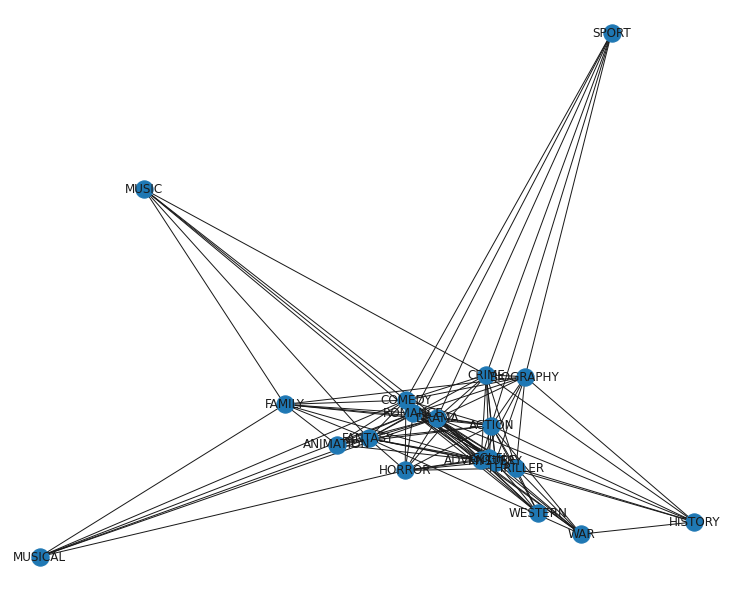

In [186]:
plt.figure(figsize=(10, 8))
nx.draw_spectral(G_genre, with_labels=True)

In [ ]:
list(nx.shortest_paths.all_shortest_paths(G_genre, source='MUSICAL',target='SPORT'))

In [ ]:
dfsim = pd.DataFrame(nx.similarity.simrank_similarity(G_genre))
dfsim.loc[:,:] = np.where(dfsim.loc[:,:]>=1, np.nan, dfsim)
dfsim = dfsim.apply(scipy.stats.zscore, nan_policy='omit')
dfsim

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dfsim)
plt.show()

## Visualization of Statistical Models

### ANOVA – ```Revenue ~ Genre * Runtime```

In [182]:
n_quantiles = 5
revenue_quantile_param = 10    # Options: {bool, int}
column_for_colorScale = 'Metascore'
dftest = data.get_dfDiscrete(data.DF, equal_quantiles=n_quantiles, include_Revenue=revenue_quantile_param)
dftest['Director_primaryGenre'] = dftest['Director'].map(DIR.Director2PrimaryGenre)
dftest['Runtime'] = dftest['Runtime'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Runtime'].dropna(), q=n_quantiles).values))[i])) for i in range(n_quantiles)))
dftest['Revenue'] = dftest['Revenue'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Revenue'].dropna(), q=revenue_quantile_param).values))[i])) for i in range(revenue_quantile_param)))
dftest[column_for_colorScale] = data.DF[column_for_colorScale]  #<==gets the unbinned values

fig = px.parallel_categories(
    data_frame=dftest,
    dimensions=[
        'Director_primaryGenre',
        'Runtime',
        'Revenue',
    ],
    color=column_for_colorScale, color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        'Director_primaryGenre':'Genre (Primary of Director)',
        'Runtime':'Runtime (Minutes)',
        'Revenue':'Revenue (Millions, $)',
    },
    title='Genre → Runtime (as quantile) → Revenue (as quantile)',
)
fig.show()
# fig.write_html('Sankey_Genre2Runtime2Revenue.html')    #<!==Uncomment to save file==!

In [183]:
n_quantiles = 5
revenue_quantile_param = 5    # Options: {bool, int}
column_for_colorScale = 'Metascore'
dftest = data.get_dfDiscrete(data.DF, equal_quantiles=False, include_Revenue=revenue_quantile_param)
dftest['Director_primaryGenre'] = dftest['Director'].map(DIR.Director2PrimaryGenre)
# dftest['Runtime'] = dftest['Runtime'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Runtime'].dropna(), q=n_quantiles).values))[i])) for i in range(n_quantiles)))
dftest['Revenue'] = dftest['Revenue'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Revenue'].dropna(), q=revenue_quantile_param).values))[i])) for i in range(revenue_quantile_param)))
dftest[column_for_colorScale] = data.DF[column_for_colorScale]  #<==gets the unbinned values

fig = px.parallel_categories(
    data_frame=dftest,
    dimensions=[
        'Director_primaryGenre',
        'Revenue',
        'Runtime',
        # 'Revenue',
    ],
    color=column_for_colorScale, color_continuous_scale=px.colors.diverging.PiYG,
    labels={
        'Director_primaryGenre':'Genre (Primary of Director)',
        'Runtime':'Runtime (Minutes)',
        'Revenue':'Revenue (Millions, $)',
    },
    title='Genre → Runtime (as quantile) → Revenue (as quantile)',
)
fig.show()
# fig.write_html('Sankey_Genre2Runtime2Revenue.html')    #<!==Uncomment to save file==!

# Resources

## Statistics Libraries

### ```statsmodels```

- [statsmodels.sandbox.stats.multicomp.MultiComparison](https://www.statsmodels.org/devel/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html)
    - See for ```tukeyhsd``` method
- [Patsy: Contrast Coding Systems for categorical variables](https://www.statsmodels.org/devel/contrasts.html#contrasts--page-root)

### ```sklearn```

- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)
- [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

## Plotting

- [Plotly: Built-In Sequential Color scales](https://plotly.com/python/builtin-colorscales/)

In [ ]:
fig = px.parallel_categories(
    data_frame=data.get_dfDiscrete().sort_values(by=['Revenue']),
    dimensions=['Genre','Rating','Votes','Metascore'],
    color="Revenue",
#     color_continuous_scale=px.colors.sequential.Inferno,
)
fig.show()

# ...

In [179]:
n_quantiles = 5
revenue_quantile_param = 10    # Options: {bool, int}
column_for_colorScale = 'Metascore'
dftest = data.get_dfDiscrete(data.DF, equal_quantiles=n_quantiles, include_Revenue=revenue_quantile_param)
dftest['Director_primaryGenre'] = dftest['Director'].map(DIR.Director2PrimaryGenre)
dftest['Runtime'] = dftest['Runtime'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Runtime'].dropna(), q=n_quantiles).values))[i])) for i in range(n_quantiles)))
dftest['Revenue'] = dftest['Revenue'].map(dict((i, str(sorted(set(pd.qcut(data.DF['Revenue'].dropna(), q=revenue_quantile_param).values))[i])) for i in range(revenue_quantile_param)))
dftest[column_for_colorScale] = data.DF[column_for_colorScale]  #<==gets the unbinned values


In [181]:
dftest

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime,Rating,Votes,Revenue,Metascore,LE_Genre,Director_primaryGenre
hash,,,,,,,,,,,,,,
-3658224656250598732,1,Guardians of the Galaxy,"(ACTION, ADVENTURE, SCI-FI)",A group of intergalactic criminals are forced ...,James Gunn,"[BRADLEY COOPER, CHRIS PRATT, VIN DIESEL, ZOE ...",2014,"(115.0, 127.0]",4,4,"(209.765, 936.63]",76.0,12,COMEDY
-2844849456231320369,2,Prometheus,"(ADVENTURE, MYSTERY, SCI-FI)","Following clues to the origin of mankind, a te...",Ridley Scott,"[CHARLIZE THERON, LOGAN MARSHALL-GREEN, MICHAE...",2012,"(115.0, 127.0]",2,4,"(93.408, 134.52]",65.0,89,DRAMA
-5025972602573733134,3,Split,"(HORROR, THRILLER)",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"[ANYA TAYLOR-JOY, HALEY LU RICHARDSON, JAMES M...",2016,"(115.0, 127.0]",3,3,"(134.52, 209.765]",62.0,195,THRILLER
-3377101873146513982,4,Sing,"(ANIMATION, COMEDY, FAMILY)","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"[MATTHEW MCCONAUGHEY, REESE WITHERSPOON, SCARL...",2016,"(106.0, 115.0]",3,1,"(209.765, 936.63]",59.0,92,FAMILY
-4259268745187087058,5,Suicide Squad,"(ACTION, ADVENTURE, FANTASY)",A secret government agency recruits some of th...,David Ayer,"[JARED LETO, MARGOT ROBBIE, VIOLA DAVIS, WILL ...",2016,"(115.0, 127.0]",1,4,"(209.765, 936.63]",40.0,8,ACTION
-5734063081512105418,6,The Great Wall,"(ACTION, ADVENTURE, FANTASY)",European mercenaries searching for black powde...,Yimou Zhang,"[ANDY LAU, MATT DAMON, TIAN JING, WILLEM DAFOE]",2016,"(97.0, 106.0]",1,1,"(34.116, 47.985]",42.0,8,ACTION
4895346832297095505,7,La La Land,"(COMEDY, DRAMA, MUSIC)",A jazz pianist falls for an aspiring actress i...,Damien Chazelle,"[EMMA STONE, J.K. SIMMONS, ROSEMARIE DEWITT, R...",2016,"(127.0, 191.0]",4,3,"(134.52, 209.765]",93.0,116,MUSIC
-4982592567240204083,8,Mindhorn,"(COMEDY,)",A has-been actor best known for playing the ti...,Sean Foley,"[ANDREA RISEBOROUGH, ESSIE DAVIS, JULIAN BARRA...",2016,"(65.999, 97.0]",1,0,NaN,71.0,108,COMEDY
7709503923317219471,9,The Lost City of Z,"(ACTION, ADVENTURE, BIOGRAPHY)","A true-life drama, centering on British explor...",James Gray,"[CHARLIE HUNNAM, ROBERT PATTINSON, SIENNA MILL...",2016,"(127.0, 191.0]",3,0,"(7.268, 19.507]",78.0,3,ACTION


In [180]:
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": ["A", "B", "C", "D", "E", "F"],
        "x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        "y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        'pad':10},  # 10 Pixels
    link = {
        "source" : [0, 0, 1, 2, 5, 4, 3, 5],
        "target" : [5, 3, 4, 3, 0, 2, 2, 3],
        "value"  : [1, 2, 1, 1, 1, 1, 1, 2],
    },
))

fig.show()

In [ ]:
pd.DataFrame.from_dict({
    "label" : ["A", "B", "C", "D", "E", "F"],
    "x"     : [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
    "y"     : [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
})

In [ ]:
pd.DataFrame.from_dict({
    "source" : [0, 0, 1, 2, 5, 4, 3, 5],
    "target" : [5, 3, 4, 3, 0, 2, 2, 3],
    "value"  : [1, 2, 1, 1, 1, 1, 1, 2],
})